# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


In [21]:
type(survey_fields)

list

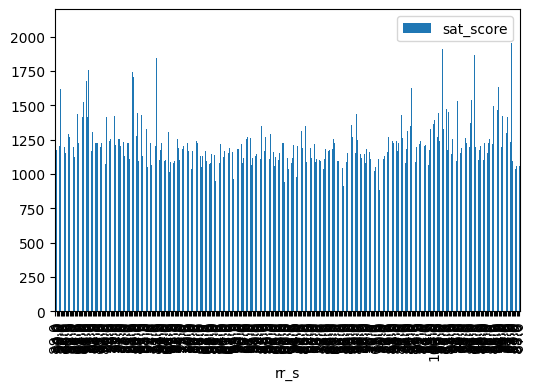

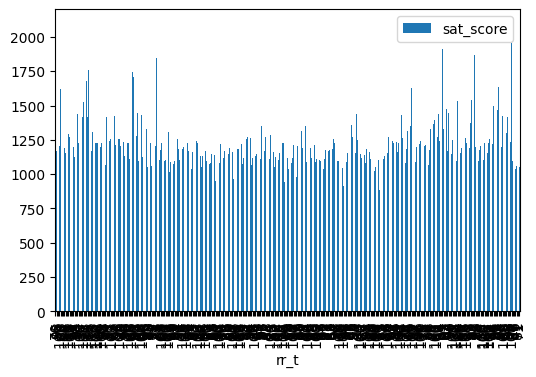

In [23]:
for i in survey_fields[:2]:
    combined.plot(kind = 'bar', x = i, y = 'sat_score')
    plt.show()

In [24]:
correlations = combined.corr()

In [25]:
correlations.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
SAT Critical Reading Avg. Score,1.000000,0.929221,0.982826,0.986820,0.490283,0.483479,0.441813,0.289710,0.035699,0.357418,...,NaN,NaN,-0.064120,0.367945,0.111556,NaN,NaN,NaN,-0.119993,-0.126479
SAT Math Avg. Score,0.929221,1.000000,0.931385,0.972643,0.545646,0.533239,0.469456,0.379012,0.078078,0.444985,...,NaN,NaN,-0.033971,0.460646,0.134403,NaN,NaN,NaN,-0.134572,-0.120055
SAT Writing Avg. Score,0.982826,0.931385,1.000000,0.987771,0.501648,0.495321,0.451790,0.282701,0.009161,0.353928,...,NaN,NaN,-0.093174,0.366308,0.096834,NaN,NaN,NaN,-0.100551,-0.143850
sat_score,0.986820,0.972643,0.987771,1.000000,0.523140,0.514333,0.463245,0.325144,0.042948,0.394626,...,NaN,NaN,-0.063977,0.407827,0.117012,NaN,NaN,NaN,-0.121029,-0.132222
AP Test Takers,0.490283,0.545646,0.501648,0.523140,1.000000,0.992192,0.901513,0.602802,0.091956,0.699954,...,NaN,NaN,0.066540,0.677453,0.178590,NaN,NaN,NaN,-0.104464,-0.053121


rr_s


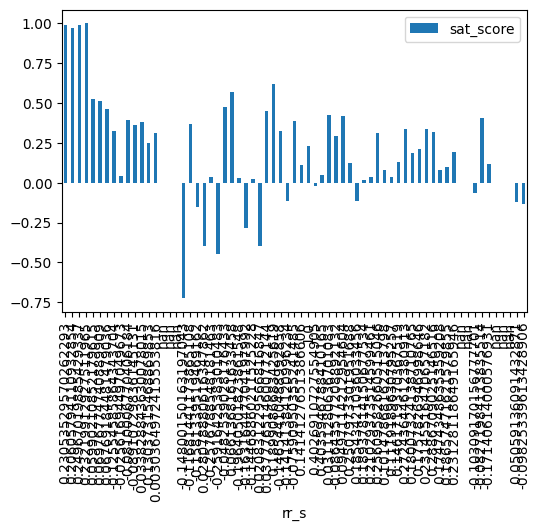

rr_t


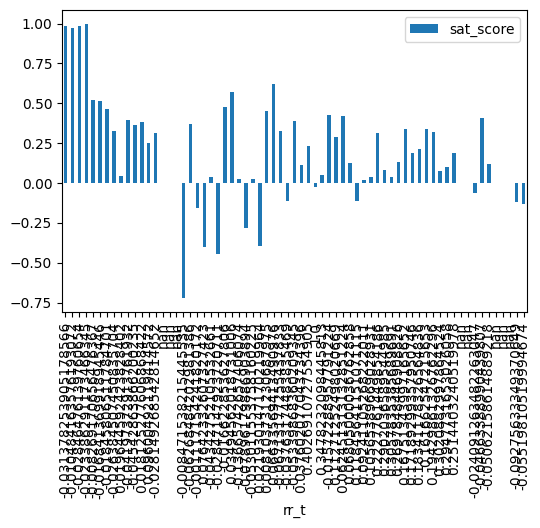

In [27]:
for i in survey_fields[:2]:
    print(i)
    correlations.plot(kind = 'bar', x = i, y = 'sat_score')
    plt.show()

In [28]:
correlations.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
SAT Critical Reading Avg. Score,1.000000,0.929221,0.982826,0.986820,0.490283,0.483479,0.441813,0.289710,0.035699,0.357418,...,NaN,NaN,-0.064120,0.367945,0.111556,NaN,NaN,NaN,-0.119993,-0.126479
SAT Math Avg. Score,0.929221,1.000000,0.931385,0.972643,0.545646,0.533239,0.469456,0.379012,0.078078,0.444985,...,NaN,NaN,-0.033971,0.460646,0.134403,NaN,NaN,NaN,-0.134572,-0.120055
SAT Writing Avg. Score,0.982826,0.931385,1.000000,0.987771,0.501648,0.495321,0.451790,0.282701,0.009161,0.353928,...,NaN,NaN,-0.093174,0.366308,0.096834,NaN,NaN,NaN,-0.100551,-0.143850
sat_score,0.986820,0.972643,0.987771,1.000000,0.523140,0.514333,0.463245,0.325144,0.042948,0.394626,...,NaN,NaN,-0.063977,0.407827,0.117012,NaN,NaN,NaN,-0.121029,-0.132222
AP Test Takers,0.490283,0.545646,0.501648,0.523140,1.000000,0.992192,0.901513,0.602802,0.091956,0.699954,...,NaN,NaN,0.066540,0.677453,0.178590,NaN,NaN,NaN,-0.104464,-0.053121


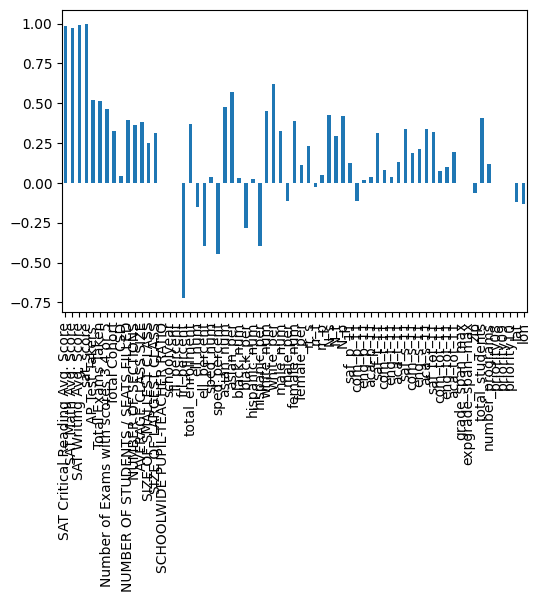

In [32]:
correlations['sat_score'].plot(kind = 'bar', x = "N_t" , y = 'sat_score')

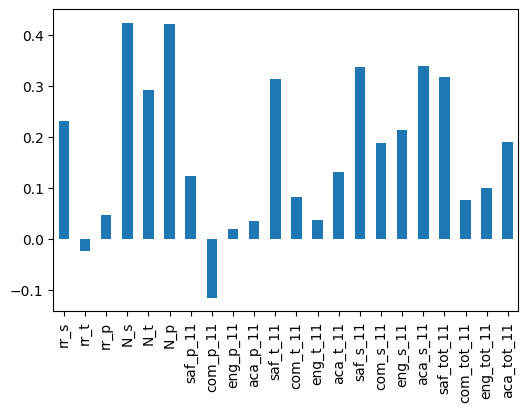

In [33]:
correlations['sat_score'][survey_fields].plot.bar()

In [36]:
print(correlations['sat_score'])

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In [37]:
print(correlations['sat_score'][survey_fields])

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


In [38]:
type(correlations)

pandas.core.frame.DataFrame

In [41]:
correlations.loc['sat_score',survey_fields]

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

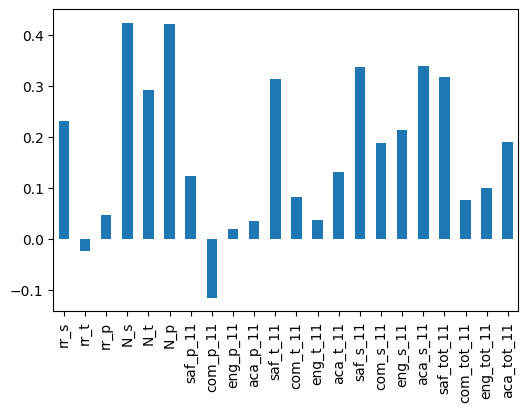

In [42]:
correlations.loc['sat_score',survey_fields].plot(kind = 'bar')

In [43]:
correlations_sat = correlations.loc['sat_score', survey_fields]

In [49]:
correlations_sat[correlations_sat[survey_fields] > 0.25].sort_values(ascending = False)

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
Name: sat_score, dtype: float64

In [46]:
correlations_sat[correlations_sat[survey_fields] > 0.5]

Series([], Name: sat_score, dtype: float64)

In [47]:
correlations_sat[correlations_sat[survey_fields] > 0.4]

N_s    0.423463
N_p    0.421530
Name: sat_score, dtype: float64

## Results:
* High correlation with :

   1. N_s   :        0.42
   
   2. N_p    :       0.42
   
   3. aca_s_11   :   0.34
   
   4. saf_s_11   :   0.337
   
   5. saf_tot_11  :  0.318
   
   6. saf_t_11   :   0.313
   
   7. N_t     :      0.291

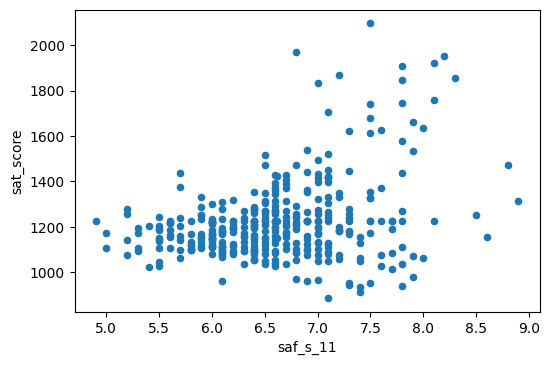

In [52]:
combined.plot(kind = 'scatter', x = 'saf_s_11' , y = 'sat_score')

### Observations: the higher the safety, the higher sat score

In [56]:
print(combined.columns)

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)


In [57]:
combined.shape


(363, 160)

In [71]:
boro_avg = combined.pivot_table(index = "boro", values = 'saf_s_11' , aggfunc = 'mean')

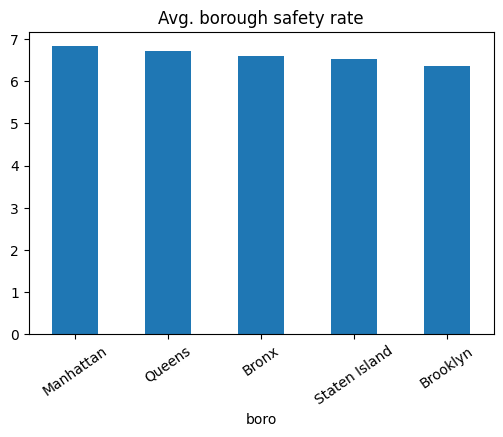

In [73]:
boro_avg.sort_values('saf_s_11' , ascending = False).plot(kind = 'bar', rot = 35, title = 'Avg. borough safety rate', legend = False)

In [76]:
race_corr = correlations.loc['sat_score', ['white_per','asian_per','black_per','hispanic_per']]
print(race_corr)

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


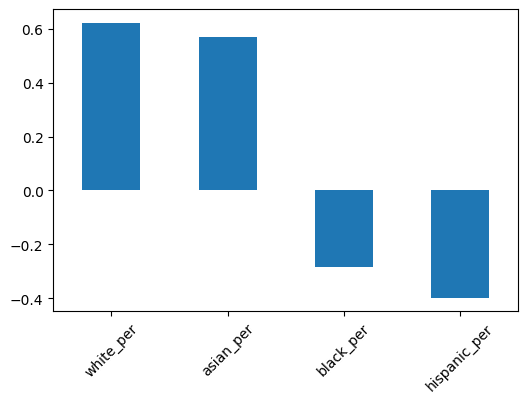

In [78]:
race_corr.plot(kind = 'bar', rot = 45)

#### Observation: 
1. the higher white and asian percentage, the higher sat score. 
2. the higher black or hispanic, the lower sat score

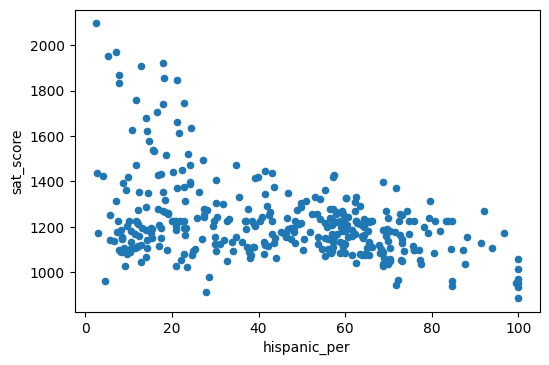

In [80]:
combined.plot(kind = 'scatter', x= 'hispanic_per', y = 'sat_score')

In [84]:
high_hispan = combined[combined['hispanic_per'] > 95]

In [85]:
high_hispan

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0.0,0.0,0.0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0.0,0.0,0.0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0.0,0.0,0.0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0.0,0.0,0.0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0.0,0.0,0.0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


In [86]:
high_hispan['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [88]:
low_hispan = combined[(combined['hispanic_per'] < 10)&(combined['sat_score'] > 1800)]

In [89]:
low_hispan['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

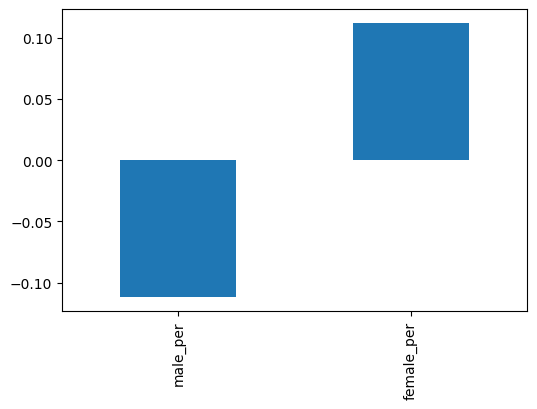

In [100]:
combined.corr().loc['sat_score',['male_per','female_per']].plot.bar()

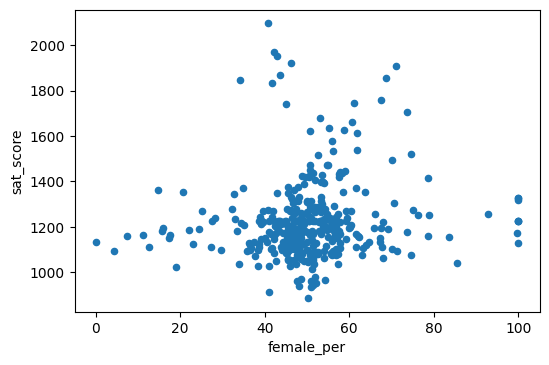

In [101]:
combined.plot(kind = 'scatter', x = 'female_per', y = 'sat_score')

In [102]:
high_female = combined[(combined['female_per'] > 60)&(combined['sat_score']>1700)]

In [103]:
high_female.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0.0,0.0,0.0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0.0,0.0,0.0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0.0,0.0,0.0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


In [104]:
print(high_female['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [105]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
print(combined['ap_per'])

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64


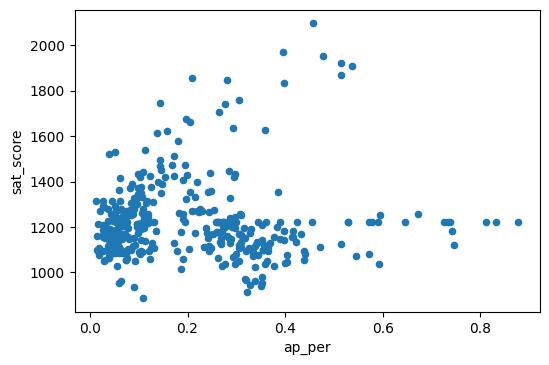

In [106]:
combined.plot(kind = 'scatter', x = 'ap_per', y = 'sat_score')

In [109]:
combined.corr().loc['sat_score','ap_per']

0.05717081390766967